In [14]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from sodapy import Socrata
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
client = Socrata("data.cityofnewyork.us", os.environ['nyc_soda_cuny_token'])

In [4]:
results = client.get("uvpi-gqnh", limit=600000)

In [5]:
trees = pd.DataFrame.from_records(results)

In [6]:
print(trees.shape)
trees.head()

(600000, 45)


,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council_district,census_tract,bin,bbl
0,180683,348711,2015-08-27T00:00:00.000,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.72309177,-73.84421522,1027431.148,202756.7687,29,739,4052307,4022210001
1,200540,315986,2015-09-03T00:00:00.000,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.79411067,-73.81867946,1034455.701,228644.8374,19,973,4101931,4044750045
2,204026,218365,2015-09-05T00:00:00.000,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.71758074,-73.9366077,1001822.831,200716.8913,34,449,3338310,3028870001
3,204337,217969,2015-09-05T00:00:00.000,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.71353749,-73.93445616,1002420.358,199244.2531,34,449,3338342,3029250001
4,189565,223043,2015-08-30T00:00:00.000,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,3016500,New York,40.66677776,-73.97597938,990913.775,182202.426,39,165,3025654,3010850052


In [7]:
cols_int = ['tree_dbh', 'stump_diam']
cols_float = ['latitude', 'longitude',
              'x_sp', 'y_sp']
for column in cols_int:
    trees[column] = trees[column].astype(int)
for column in cols_float:
    trees[column] = trees[column].astype(float)

In [8]:
trees['boroname'].value_counts()

Queens           224748
Brooklyn         150555
Staten Island     97500
Bronx             78593
Manhattan         48604
Name: boroname, dtype: int64

In [9]:
boro_data = trees['boroname'].value_counts().reset_index()
boro_data

,index,boroname
0,Queens,224748
1,Brooklyn,150555
2,Staten Island,97500
3,Bronx,78593
4,Manhattan,48604


In [10]:
boro_data = boro_data.rename(columns={'index':'boro', 
                                      'boroname': 'count'})
boro_data

,boro,count
0,Queens,224748
1,Brooklyn,150555
2,Staten Island,97500
3,Bronx,78593
4,Manhattan,48604


In [21]:
boro_data['boro'].tolist()

['Queens', 'Brooklyn', 'Staten Island', 'Bronx', 'Manhattan']

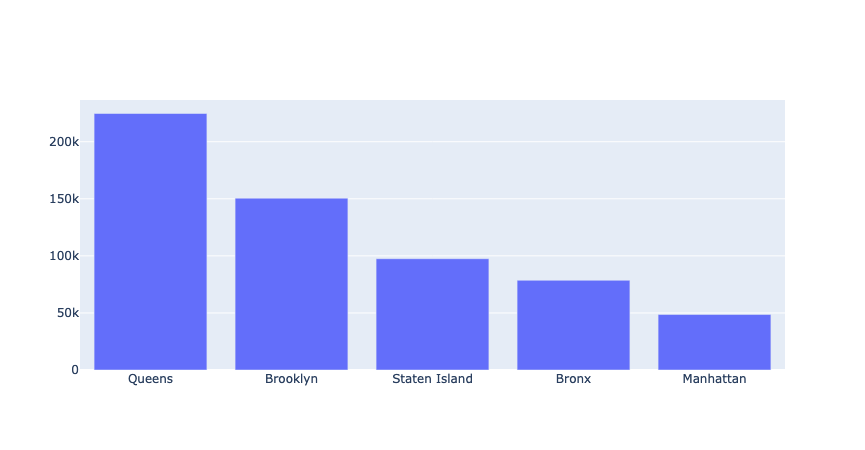

In [27]:
fig = go.Figure(
    go.Bar(
        x=boro_data['boro'], y=boro_data['count'])
)

fig.show(
    config= {'displaylogo': False, 
             'displayModeBar': False}
)

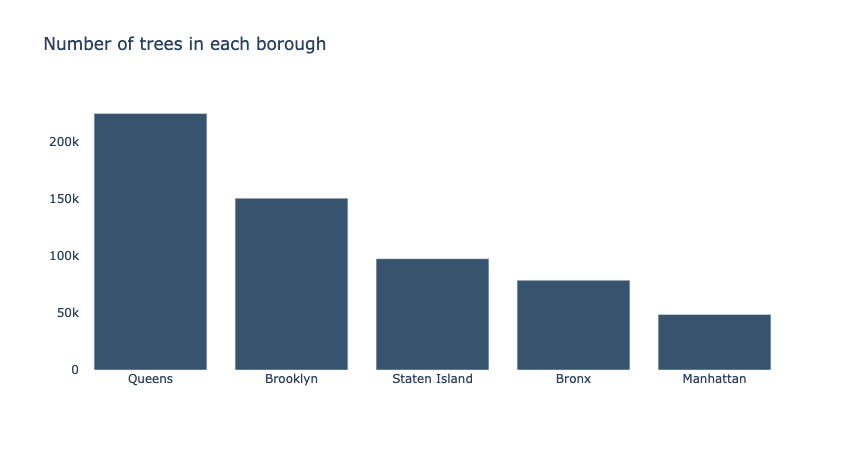

In [29]:
layout = go.Layout(
    plot_bgcolor='rgba(255,255,255,1)',
    title='Number of trees in each borough'
)

fig = go.Figure(
    go.Bar(
        x=boro_data['boro'], y=boro_data['count'],
    marker_color='rgb(55, 83, 109)'), 
    layout=layout
)

fig.show(
    config= {'displaylogo': False, 
             'displayModeBar': False}
)

In [37]:
trees.groupby(['boroname', 'health']).agg({'tree_id':'count'})

tree_id
boroname      health         
Bronx         Fair       9587
              Good      61985
              Poor       2774
Brooklyn      Fair      20298
              Good     118480
              Poor       5307
Manhattan     Fair       8801
              Good      34684
              Poor       2831
Queens        Fair      29324
              Good     176324
              Poor       7957
Staten Island Fair      13215
              Good      76799
              Poor       3908

In [41]:
boro_health = trees.groupby(['boroname', 'health'])\
                   .agg({'tree_id':'count'})\
                   .reset_index()\
                   .rename(columns={'tree_id': 'count'})
boro_health.head()

,boroname,health,count
0,Bronx,Fair,9587
1,Bronx,Good,61985
2,Bronx,Poor,2774
3,Brooklyn,Fair,20298
4,Brooklyn,Good,118480


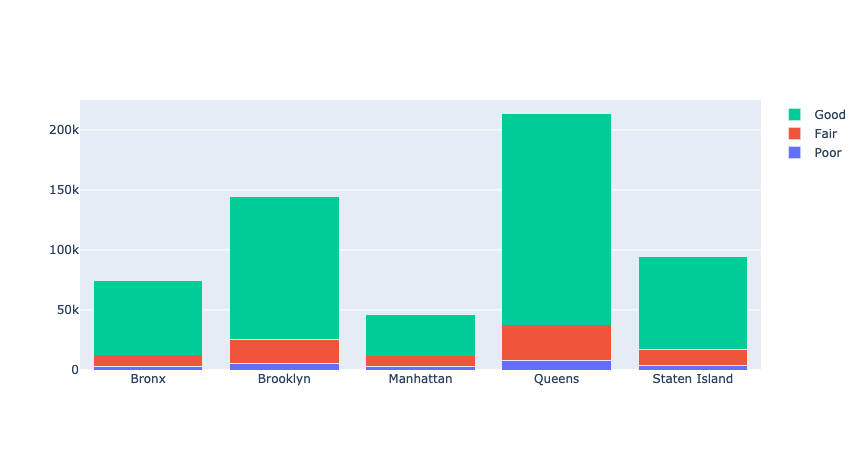

In [45]:
fig = go.Figure(
    data=[
        go.Bar(name='Poor',
               x=boro_health['boroname'].loc[boro_health['health']=='Poor'], 
               y=boro_health['count'].loc[boro_health['health']=='Poor']),
        go.Bar(name='Fair',
               x=boro_health['boroname'].loc[boro_health['health']=='Fair'], 
               y=boro_health['count'].loc[boro_health['health']=='Fair']),
        go.Bar(name='Good',
               x=boro_health['boroname'].loc[boro_health['health']=='Good'], 
               y=boro_health['count'].loc[boro_health['health']=='Good'])
])

fig.update_layout(barmode='stack')

fig.show(
    config= {'displaylogo': False, 
             'displayModeBar': False}
)

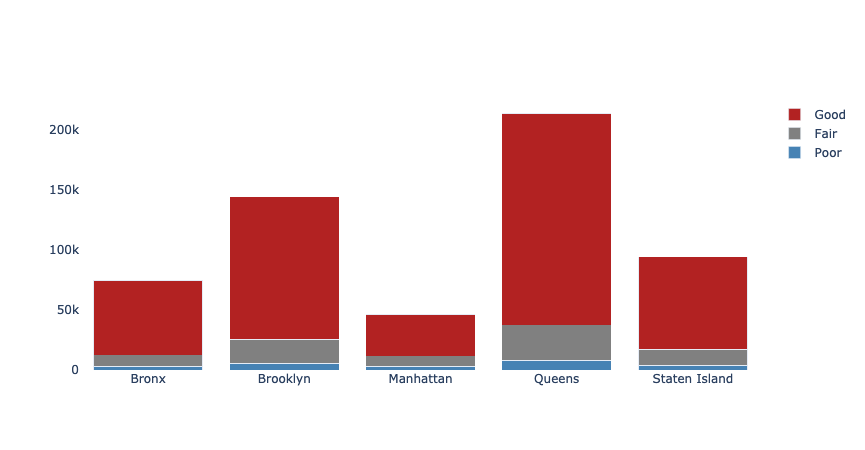

In [51]:
health_levels = ['Poor', 'Fair', 'Good']
colors = ['steelblue', 'grey', 'firebrick']

fig = go.Figure(
    data=[
        go.Bar(name=health,
               x=boro_health['boroname'].loc[boro_health['health']==health], 
               y=boro_health['count'].loc[boro_health['health']==health],
               marker_color=colors[idx]) for idx, health in enumerate(health_levels)
])

fig.update_layout(barmode='stack', 
                  plot_bgcolor='rgba(255,255,255,1)')

fig.show(
    config= {'displaylogo': False, 
             'displayModeBar': False}
)

In [78]:
trees.groupby(['boroname', 'zipcode'])['status'].value_counts()

boroname       zipcode  status
Bronx          10451    Alive      2189
                        Dead        109
                        Stump        71
               10452    Alive      2845
                        Dead        178
                                  ...  
Staten Island  10312    Stump       484
                        Dead        302
               10314    Alive     14643
                        Dead        295
                        Stump       201
Name: status, Length: 556, dtype: int64

In [82]:
zip_status = trees.groupby(['boroname', 'zipcode', 'status'])\
                  .agg({'status':'count'})\
                  .rename(columns={'status':'count'})\
                  .reset_index()
zip_health = trees.groupby(['boroname', 'zipcode', 'health'])\
                  .agg({'health':'count'})\
                  .rename(columns={'health':'h_count'})\
                  .reset_index()

In [85]:
data = pd.merge(zip_status, zip_health, on=['boroname', 'zipcode'])
data.head()

,boroname,zipcode,status,count,health,h_count
0,Bronx,10451,Alive,2189,Fair,439
1,Bronx,10451,Alive,2189,Good,1565
2,Bronx,10451,Alive,2189,Poor,185
3,Bronx,10451,Dead,109,Fair,439
4,Bronx,10451,Dead,109,Good,1565


In [86]:
data = data[(data['status']=='Alive') & (data['health']=='Poor')]
data.head()

,boroname,zipcode,status,count,health,h_count
2,Bronx,10451,Alive,2189,Poor,185
11,Bronx,10452,Alive,2845,Poor,165
20,Bronx,10453,Alive,2793,Poor,98
29,Bronx,10454,Alive,1352,Poor,46
38,Bronx,10455,Alive,1639,Poor,57


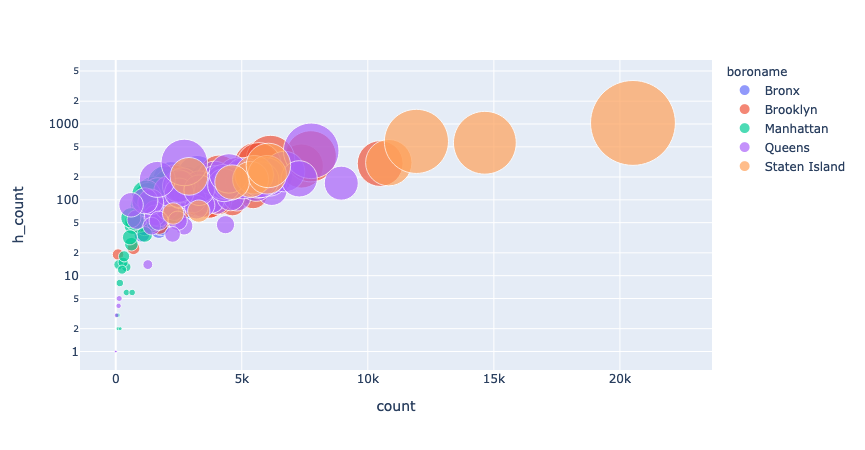

In [90]:
fig = px.scatter(data, x="count", y="h_count",
                 size="h_count", color="boroname",
                 hover_name="zipcode", log_y=True, size_max=60)
fig.show(
    config= {'displaylogo': False, 
             'displayModeBar': False}
)